In [98]:
import numpy as np

import matplotlib.pyplot as plt

#this is the way I've found to get jax to use multiple CPU cores on Apple Silicon
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"

# add the root directory to path to allow import of the uniform disk model
import sys
sys.path.append("..")
from core.uniformdisks import jinc, vis_ud

import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev

import numpyro
from numpyro import distributions as dist, infer

from numpy import genfromtxt
import pandas as pd
import arviz as az
import corner

In [115]:
try:
    from colorpy import ciexyz
    from colorpy import colormodels
    colorpy_exists=True
except:
    colorpy_exists=False
    from matplotlib import cm

## Read in the baselines:

In [116]:
df = pd.read_csv('upsUMa_l0l1.res_l1l2.res',delim_whitespace=True,comment='#',header=0)

df = df[(df.V2CALERR>0.0)]#*(df.V2CALERR<0.2)]

In [117]:
u = df[df['STAR']=='HD_84999']['UCOORDS'].values
v = df[df['STAR']=='HD_84999']['VCCORDS'].values
wav = df[df['STAR']=='HD_84999']['LAMBDA'].values
v2 = df[df['STAR']=='HD_84999']['V2CAL'].values
v2_err = df[df['STAR']=='HD_84999']['V2CALERR'].values

In [118]:
if colorpy_exists:
    irgb = []
    for i in wav:
        xyz = ciexyz.xyz_from_wavelength(i*1000)
        irgb.append(colormodels.irgb_from_xyz(xyz))
    irgb = np.array(irgb)/255
else:
    irgb = cm.jet(wav)

Text(0, 0.5, 'V (baseline/$\\lambda$)')

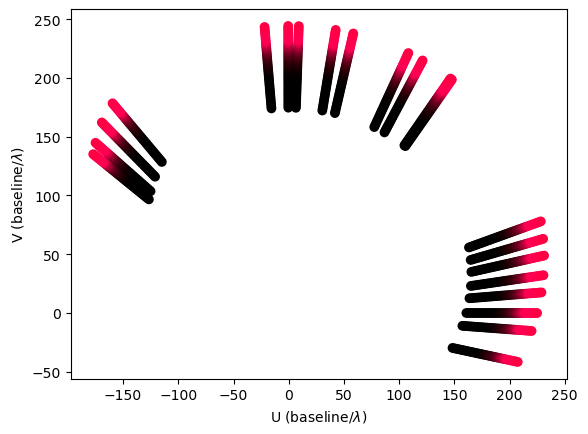

In [119]:
plt.scatter(u/wav,v/wav, c=irgb)
plt.xlabel(r"U (baseline/$\lambda$)")
plt.ylabel(r"V (baseline/$\lambda$)")

## Plot the visibilities

array([<AxesSubplot:xlabel='baseline/$\\lambda$', ylabel='$V^2$'>,
       <AxesSubplot:xlabel='$\\theta$', ylabel='$V^2$'>], dtype=object)

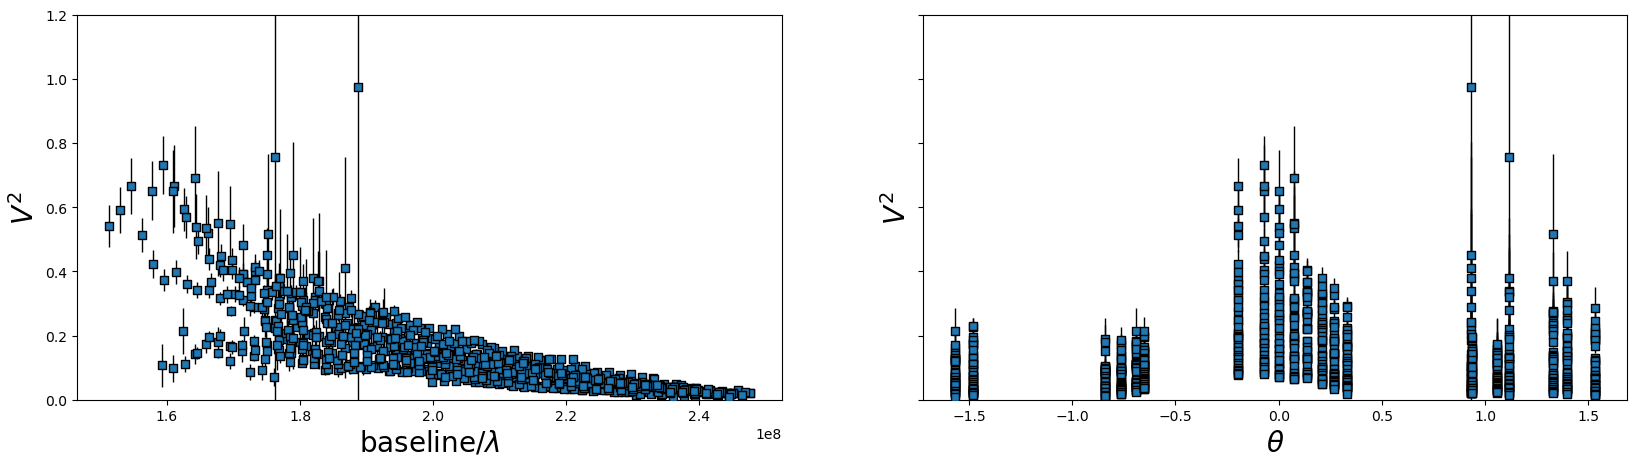

In [120]:
cmap = plt.get_cmap("hsv")
cmap2 = plt.get_cmap("viridis")

true_params = [0]
x = jnp.hypot(u/(wav*1e-6),v/(wav*1e-6))
theta = jnp.arctan(v/u)
y = v2
yerr = v2_err

u0 = jnp.linspace(0,u.max(),len(wav))/(wav*1e-6)
v0 = jnp.linspace(0,v.max(),len(wav))/(wav*1e-6)
x0 = jnp.hypot(u0,v0)
y0 = vis_ud(true_params[0],u0,v0)**2


def plot_data(x,y, x0, y0, yerr, wavels=wav, ax=None, alpha=1):
    if ax is None:
        fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
    ax[0].errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    
#     if wavels is not None:
    ax[0].scatter(x, y, marker="s", s=30, edgecolor="k", zorder=1000)
#     else:
#         ax[0].scatter(x, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap(x))
    ax[0].plot(x0, y0, color="k", lw=1.5, alpha=alpha)
    ax[0].set_xlabel("baseline/$\lambda$", fontsize=20)
    ax[0].set_ylabel("$V^2$", fontsize=20)
    ax[0].set_ylim(0, 1.2)
    
    ax[1].errorbar(theta, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[1].scatter(theta, y, marker="s", s=30, edgecolor="k", zorder=1000)
    ax[1].set_xlabel(r"$\theta$", fontsize=20)
    ax[1].set_ylabel("$V^2$", fontsize=20)
    ax[1].set_ylim(0, 1.2)
    
    return ax


plot_data(x,y,x0,y0,yerr)

In [121]:
numpyro.set_host_device_count(2)

def model(u, v, yerr, wavel, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    diam = numpyro.sample("diam", dist.Uniform(0.0001, 1.0))
    
    with numpyro.plate("data", len(u)):
        numpyro.sample("y", dist.Normal(vis_ud(diam,u/wavel,v/wavel)**2, yerr), obs=y)

In [122]:
print(np.min(wav), np.max(wav))
print(np.min(u),np.max(u))
print(np.min(v),np.max(v))
print(np.min(y),np.max(y))
print(np.min(yerr),np.max(yerr))
print(np.min(theta),np.max(theta))


0.63 0.881
-111.5613 145.7358
-26.3266 153.9607
0.0077 0.9745
0.0018 1.7334
-1.5688373878305435 1.533394246396621


In [123]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
samplers = []

# for i, th in enumerate(np.unique(theta)):
#         df2 = df[np.array(theta==th) * np.array(df['STAR']=='HD_84999')]
df2 = df[np.array(df['STAR']=='HD_84999')]

u = np.array(df2['UCOORDS'].values)
v = np.array(df2['VCCORDS'].values)
wav = np.array(df2['LAMBDA'].values)
v2 = np.array(df2['V2CAL'].values)
v2_err = np.array(df2['V2CALERR'].values)

x = jnp.hypot(u/(wav*1e-6),v/(wav*1e-6))
theta = jnp.arctan(v/u)
y = v2
yerr = v2_err

print(np.min(wav), np.max(wav))
print(np.min(u),np.max(u))
print(np.min(v),np.max(v))
print(np.min(v2),np.max(v2))
print(np.min(v2_err),np.max(v2_err))
print(np.min(theta),np.max(theta))

samplers.append(infer.MCMC(
infer.NUTS(model),
num_warmup=2500,
num_samples=2000,
num_chains=2,
progress_bar=True,
))

samplers[0].run(jax.random.PRNGKey(0), 
                     u, v, yerr,
                wavel=wav*1e-6, y=y)

0.63 0.881
-111.5613 145.7358
-26.3266 153.9607
0.0077 0.9745
0.0018 1.7334
-1.5688373878305435 1.533394246396621


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

In [124]:
r = jnp.sqrt(u**2+v**2)
mas2rad = jnp.pi / 180.0 / 3600.0/ 1000.0
diam = 10.
d = diam*mas2rad
t = jinc(jnp.pi*d*r/wav/1e-6)
print(t)
vis_ud(diam,u/wav/1e-6,v/wav/1e-6)**2

[ 4.22084626e-03  7.11265845e-03  9.49637905e-03  1.11200865e-02
  1.18565859e-02  1.16411745e-02  1.05215652e-02  8.65400172e-03
  6.13812570e-03  3.06212150e-03 -3.48972325e-04 -3.65076160e-03
 -6.82895940e-03 -9.49962965e-03 -1.17031755e-02 -1.32200360e-02
 -1.40727856e-02 -1.42154553e-02 -1.36083102e-02 -1.22474196e-02
 -1.01305591e-02 -7.56806699e-03 -4.51812202e-03 -1.31490882e-03
  1.99458362e-03  5.46362407e-03  8.85868445e-03  1.20121289e-02
  1.48385676e-02  1.73206751e-02  1.94708332e-02  2.11388354e-02
  2.23263555e-02  2.29293182e-02  2.30060090e-02  2.26023090e-02
  2.17972270e-02 -4.58121503e-03 -1.29531461e-03  2.11041042e-03
  5.31678265e-03  8.11119459e-03  1.01814798e-02  1.14733488e-02
  1.18892262e-02  1.14560384e-02  1.01590484e-02  8.05577196e-03
  5.45114586e-03  2.38818391e-03 -7.28018381e-04 -3.90462140e-03
 -6.79081947e-03 -9.36271473e-03 -1.15139312e-02 -1.31101135e-02
 -1.40400203e-02 -1.42194972e-02 -1.36568622e-02 -1.23870472e-02
 -1.05788566e-02 -8.30939

Array([1.78155432e-05, 5.05899102e-05, 9.01812150e-05, 1.23656324e-04,
       1.40578629e-04, 1.35516943e-04, 1.10703333e-04, 7.48917458e-05,
       3.76765872e-05, 9.37658807e-06, 1.21781683e-07, 1.33280603e-05,
       4.66346866e-05, 9.02429636e-05, 1.36964317e-04, 1.74769353e-04,
       1.98043294e-04, 2.02079170e-04, 1.85186107e-04, 1.49999286e-04,
       1.02628227e-04, 5.72756380e-05, 2.04134265e-05, 1.72898519e-06,
       3.97836381e-06, 2.98511880e-05, 7.84762901e-05, 1.44291240e-04,
       2.20183088e-04, 3.00005786e-04, 3.79113347e-04, 4.46850361e-04,
       4.98466149e-04, 5.25753632e-04, 5.29276452e-04, 5.10864372e-04,
       4.75119107e-04, 2.09875312e-05, 1.67783994e-06, 4.45383216e-06,
       2.82681777e-05, 6.57914777e-05, 1.03662532e-04, 1.31637732e-04,
       1.41353699e-04, 1.31240817e-04, 1.03206264e-04, 6.48954618e-05,
       2.97149912e-05, 5.70342237e-06, 5.30010763e-07, 1.52460683e-05,
       4.61152291e-05, 8.76604270e-05, 1.32570611e-04, 1.71875077e-04,
      

In [125]:
jacfwd(vis_ud)(diam,u/wav/1e-6,v/wav/1e-6)**2

Array([8.71929566e-04, 6.36589537e-04, 3.58425319e-04, 1.24224610e-04,
       5.47366110e-06, 4.14746927e-05, 2.19953287e-04, 4.83241161e-04,
       7.67658553e-04, 1.00401291e-03, 1.12140115e-03, 1.08908318e-03,
       9.21566367e-04, 6.76616137e-04, 4.02048257e-04, 1.74104189e-04,
       3.12577726e-05, 6.23097802e-06, 1.13997113e-04, 3.44064001e-04,
       6.66480589e-04, 9.97097293e-04, 1.30477979e-03, 1.52784423e-03,
       1.65158408e-03, 1.66627317e-03, 1.56830008e-03, 1.37930705e-03,
       1.13100107e-03, 8.52401056e-04, 5.65976258e-04, 3.15311522e-04,
       1.21790825e-04, 1.86799140e-05, 5.32676736e-06, 7.55672497e-05,
       2.12444560e-04, 9.20161649e-04, 1.01797455e-03, 9.74283979e-04,
       7.95767552e-04, 5.29434070e-04, 2.64112124e-04, 6.82955693e-05,
       6.71169914e-09, 7.20054612e-05, 2.74480233e-04, 5.58236703e-04,
       8.31121064e-04, 1.03930613e-03, 1.12500228e-03, 1.08063066e-03,
       9.24373333e-04, 6.91502748e-04, 4.28232458e-04, 1.91721309e-04,
      

0
0
0


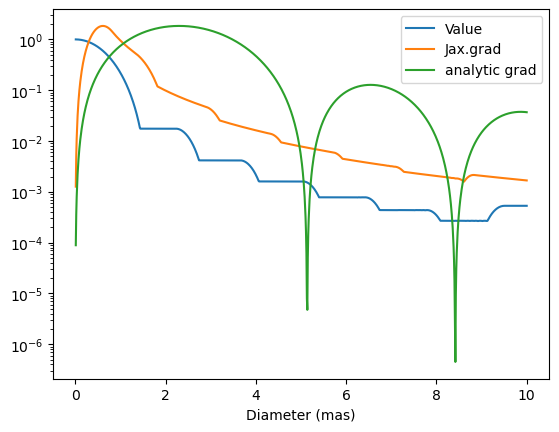

In [126]:
from scipy.special import j0, j1, jn

vals, grads, grads_analytic = [], [], []
diams = jnp.linspace(0.01,10.0,1000)
mas2rad = jnp.pi / 180.0 / 3600.0/ 1000.0

def j1_jax(x):
    return jax.scipy.special.bessel_jn(x,v=1,n_iter=30)[1]

def j0_jax(x):
    return jax.scipy.special.bessel_jn(x,v=0,n_iter=30)[0]

# @jit
@vmap
def jinc(x):
    dummy = 2*(j1_jax(x)/x)
    return dummy
    # return jax.lax.select(~jnp.isfinite(dummy), 1., dummy)


def vis_ud(d,u,v):
    """
    Takes: star diameter in milliarcseconds, u and v in baseline/wavelength
    returns: visibility
    """
    r = jnp.sqrt(u**2+v**2)
    diam = d*mas2rad
    t = jinc(jnp.pi*diam*r)
    return t

def grad_analytic(d,u,v):
    
    r = jnp.sqrt(u**2+v**2)
    diam = d*mas2rad
    x = d
    return r*jnp.pi*mas2rad*(x*j0(x) - 2*j1(x) - x*jn(2,x))/(x**2)
    
for diam in diams:
    grads_analytic.append(np.max(grad_analytic(diam,u/wav/1e-6,v/wav/1e-6)**2))
    vals.append(np.max(vis_ud(diam,u/wav/1e-6,v/wav/1e-6)**2))
    grads.append(np.max(jacfwd(vis_ud)(diam,u/wav/1e-6,v/wav/1e-6)**2))

print(np.sum(~np.isfinite(vals)))
print(np.sum(~np.isfinite(grads)))
print(np.sum(~np.isfinite(grads_analytic)))

plt.plot(diams,vals, label='Value')
plt.plot(diams,grads, label="Jax.grad")
plt.plot(diams, grads_analytic, label='analytic grad')
plt.yscale("log")
plt.xlabel('Diameter (mas)')
plt.legend()

for bad in diams[~np.isfinite(grads)]:
    plt.axvline(bad,color='k')

In [99]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
numpyro.set_host_device_count(4)

def model(u, v, yerr, wavel, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    logdiam = numpyro.sample("log diam", dist.Normal(0, 1))
    diam = numpyro.deterministic("diam", jnp.exp(logdiam))
    
    with numpyro.plate("data", len(u)):
        numpyro.sample("y", dist.Normal(vis_ud(diam,u/wavel,v/wavel)**2, yerr), obs=y)

samplers = []

u = np.array(df['UCOORDS'].values)
v = np.array(df['VCCORDS'].values)

theta = jnp.arctan(v/u)

for i, th in enumerate(np.unique(theta)):
    df2 = df[np.array(theta==th) * np.array(df['STAR']=='HD_84999')]

    u = jnp.array(df2['UCOORDS'].values)
    v = jnp.array(df2['VCCORDS'].values)
    wav = jnp.array(df2['LAMBDA'].values)
    v2 = jnp.array(df2['V2CAL'].values)
    v2_err = jnp.array(df2['V2CALERR'].values)

    x = jnp.hypot(u/(wav*1e-6),v/(wav*1e-6))
    y = v2
    yerr = v2_err
    print(u.shape, v.shape, y.shape, wav.shape)

    samplers.append(infer.MCMC(
    infer.NUTS(model),
    num_warmup=2500,
    num_samples=2000,
    num_chains=4,
    progress_bar=True,
    ))

    samplers[i].run(jax.random.PRNGKey(0), 
                         u, v, yerr,
                    wavel=wav*1e-6, y=y)

/var/folders/_t/bqm0d4gd4gb4w_d2p9j445h00000gq/T/ipykernel_24752/1869887063.py:35: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 2. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  samplers.append(infer.MCMC(


(38,) (38,) (38,) (38,)




  0%|                                                  | 0/4500 [00:00<?, ?it/s]

warmup:   0%| | 1/4500 [00:00<59:47,  1.25it/s, 1 steps of size 2.34e+00. acc. p

warmup:   6%| | 277/4500 [00:00<00:10, 420.30it/s, 3 steps of size 6.26e-02. acc

warmup:  13%|▏| 563/4500 [00:00<00:04, 855.00it/s, 3 steps of size 6.51e-01. acc

warmup:  19%|▏| 854/4500 [00:01<00:02, 1271.92it/s, 15 steps of size 2.90e-01. a

warmup:  25%|▎| 1142/4500 [00:01<00:02, 1632.68it/s, 1 steps of size 4.63e-01. a

warmup:  32%|▎| 1434/4500 [00:01<00:01, 1944.65it/s, 3 steps of size 8.57e-01. a

warmup:  38%|▍| 1728/4500 [00:01<00:01, 2199.65it/s, 1 steps of size 7.32e-01. a

warmup:  45%|▍| 2020/4500 [00:01<00:01, 2393.10it/s, 3 steps of size 5.84e-01. a

warmup:  51%|▌| 2313/4500 [00:01<00:00, 2540.90it/s, 3 steps of size 1.06e+00. a

sample:  58%|▌| 2605/4500 [00:01<00:00, 2646.40it/s, 3 steps of size 8.50e-01. a

sample:  64%|▋| 2894/4500 [00:01<00:00, 2715.63it/s, 3 steps of size 8.50e-01. a

sample:  71%|▋

KeyboardInterrupt: 

<ErrorbarContainer object of 3 artists>

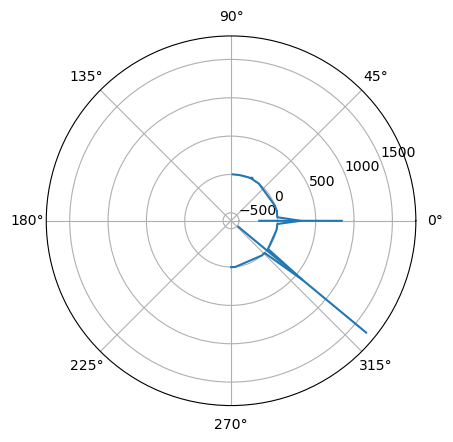

In [95]:
diams = []
diams_err = []
for i, th in enumerate(np.unique(theta)):
    inf_data = az.from_numpyro(samplers[i])
    diams.append(np.mean(inf_data.posterior.diam.values))
    diams_err.append(np.std(inf_data.posterior.diam.values))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.errorbar(np.unique(theta),np.array(diams),yerr=np.array(diams_err))

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**backend_kwargs)


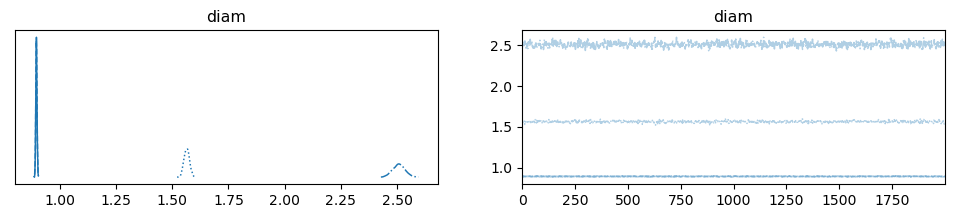

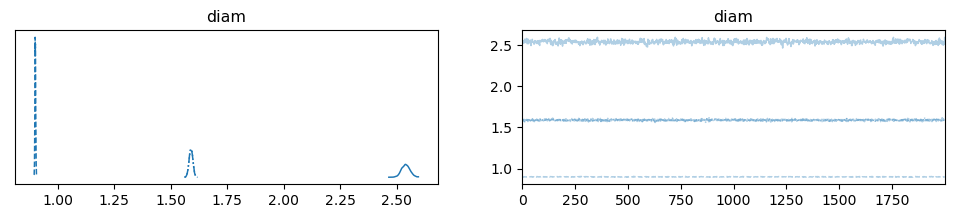

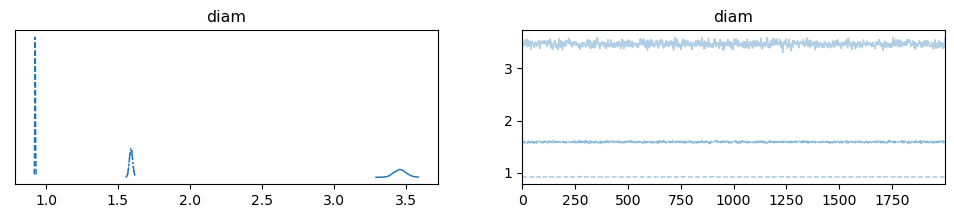

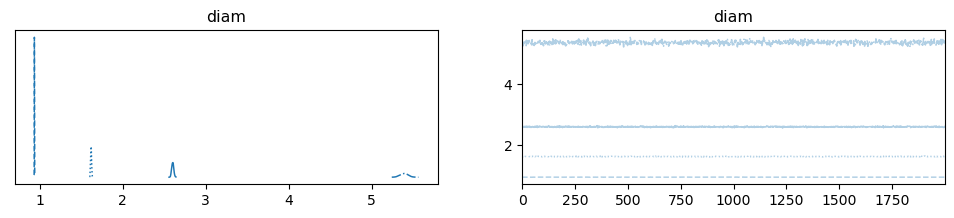

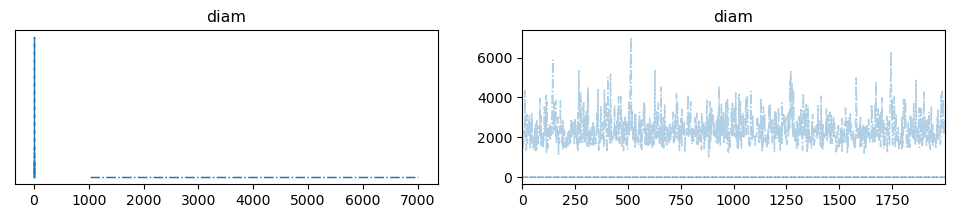

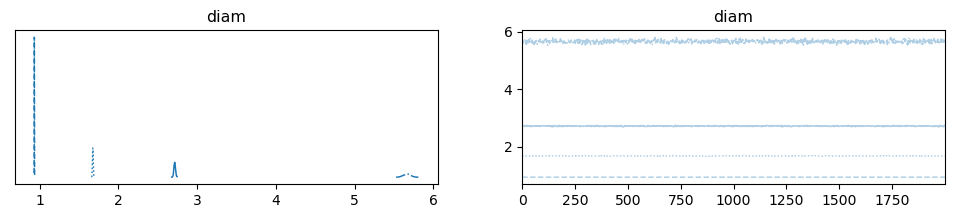

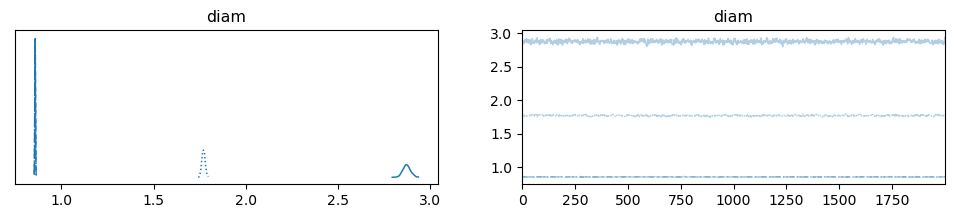

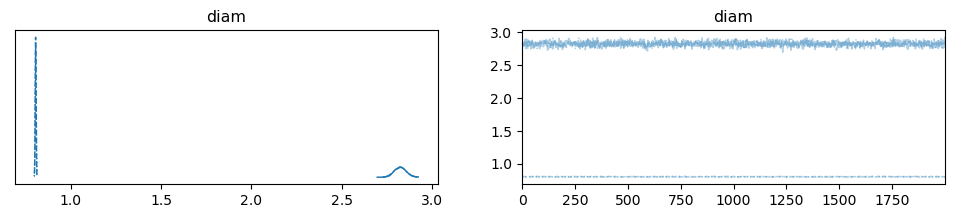

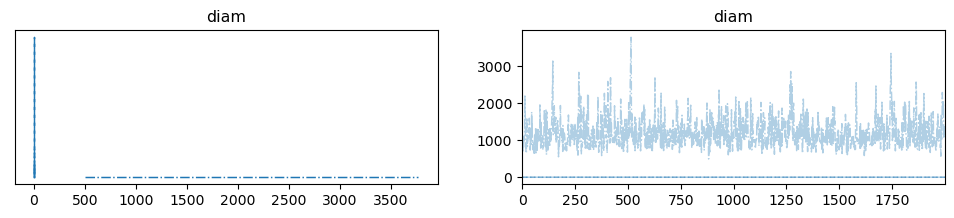

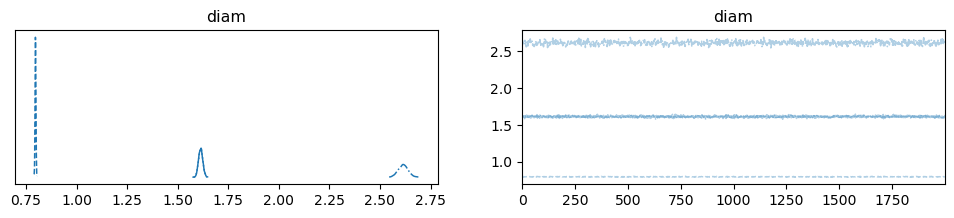

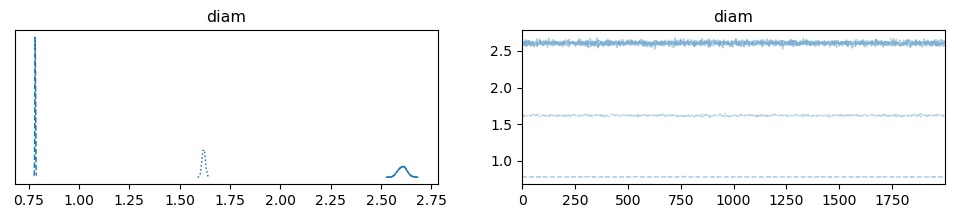

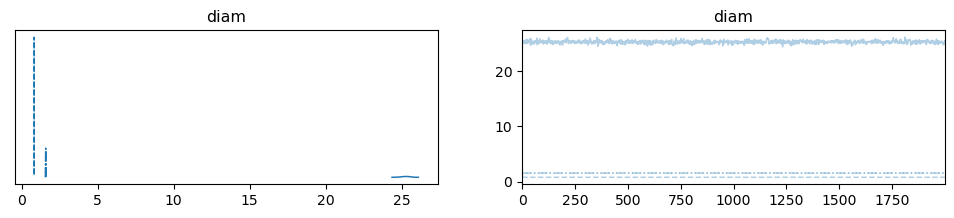

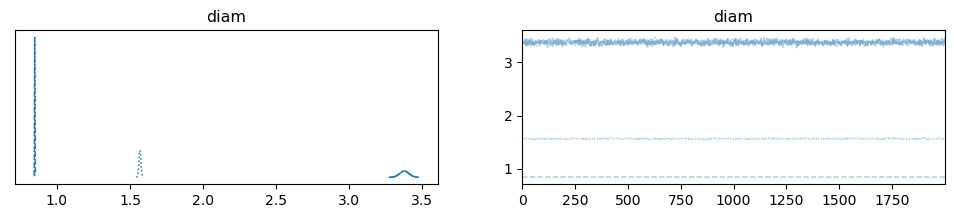

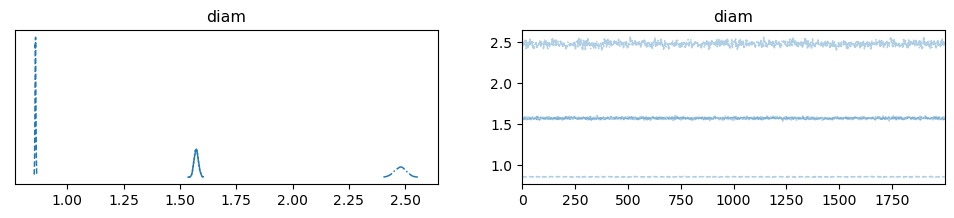

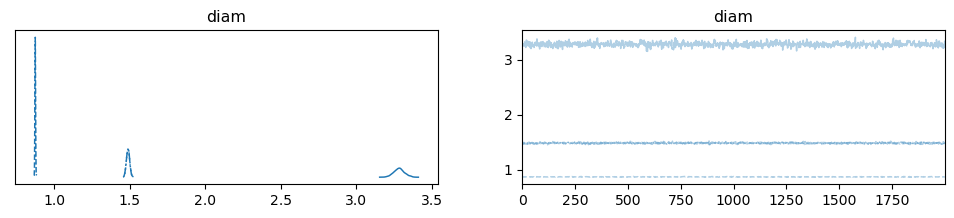

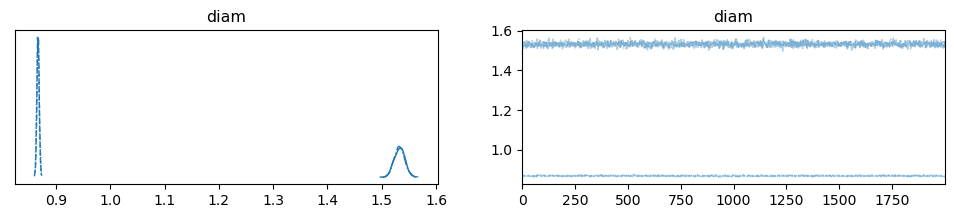

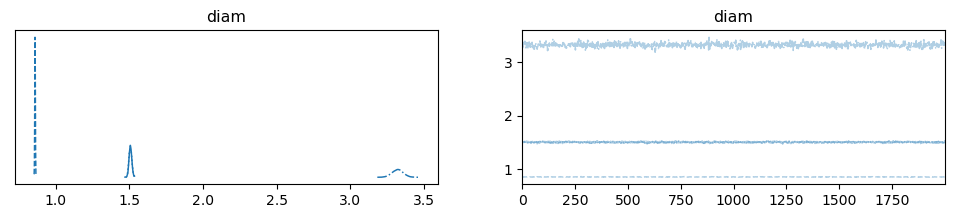

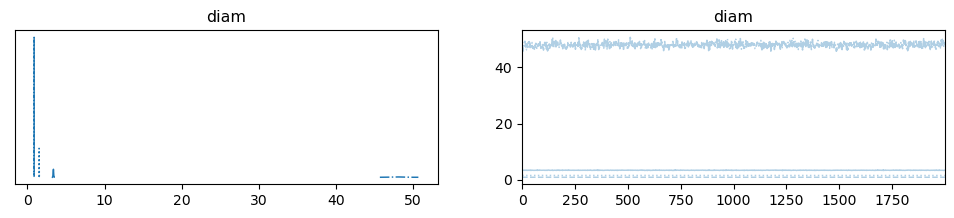

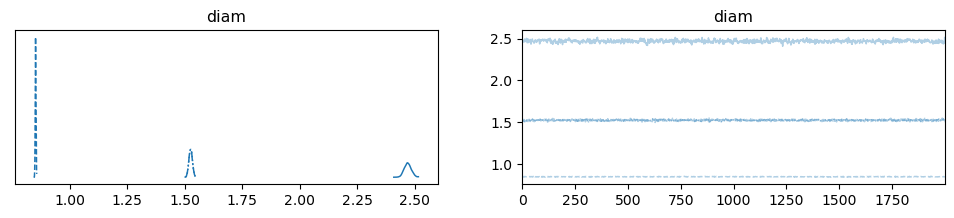

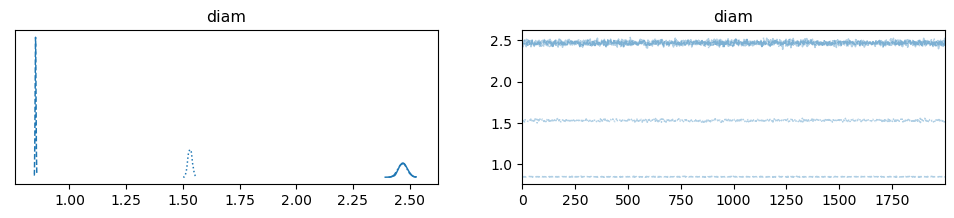

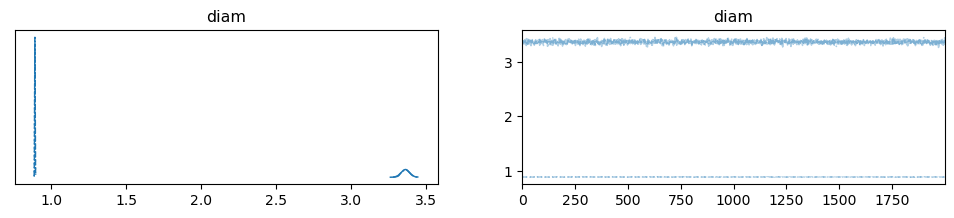

In [96]:
for i, th in enumerate(np.unique(theta)):
    inf_data = az.from_numpyro(samplers[i])
    az.plot_trace(inf_data, var_names=('diam'))

/var/folders/_t/bqm0d4gd4gb4w_d2p9j445h00000gq/T/ipykernel_24752/365107801.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=(10,5))


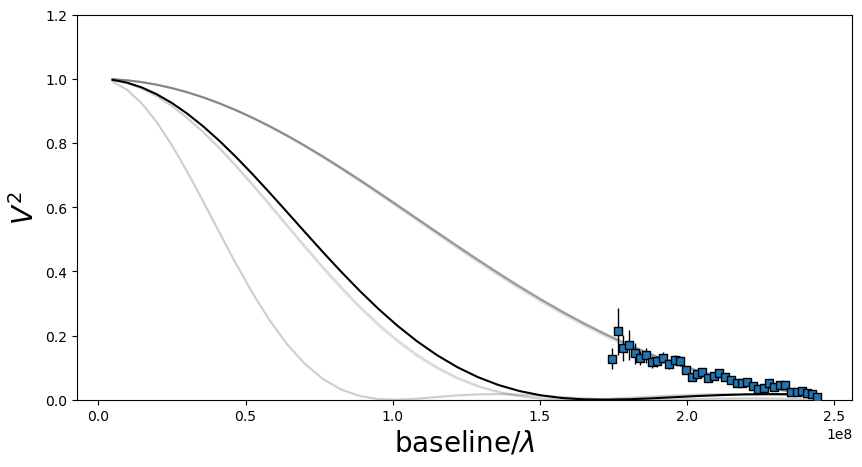

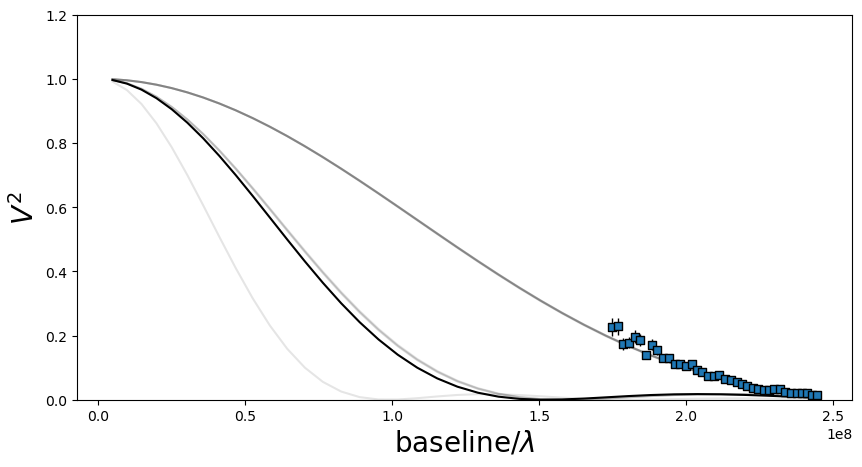

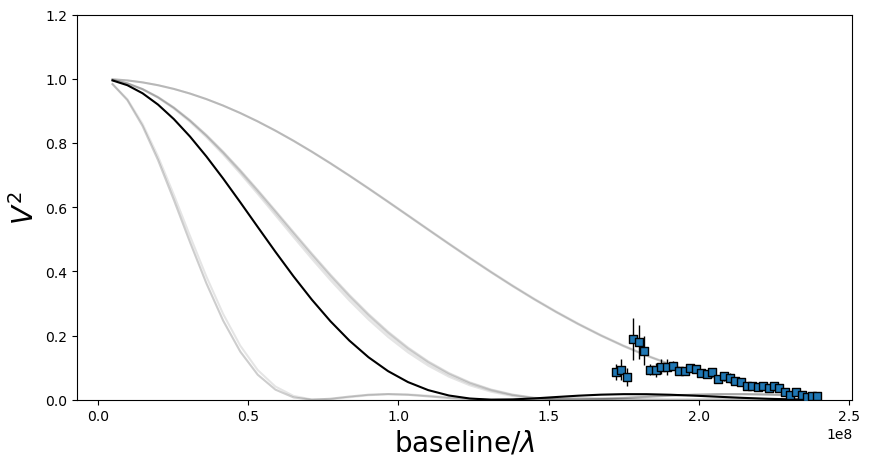

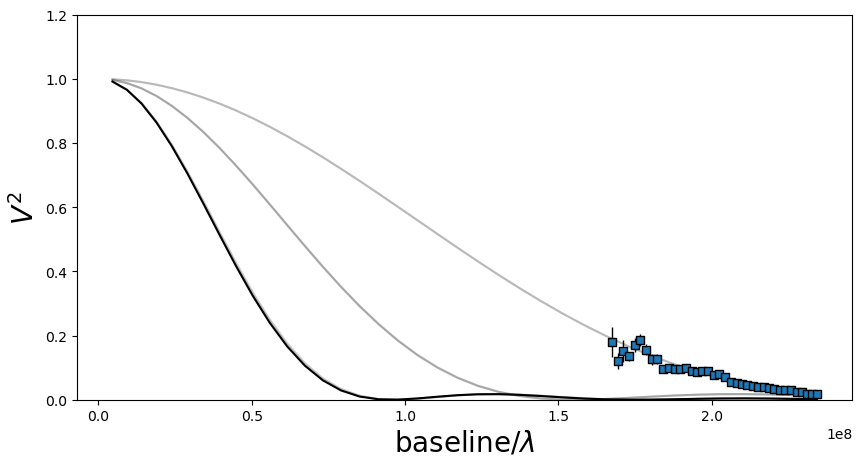

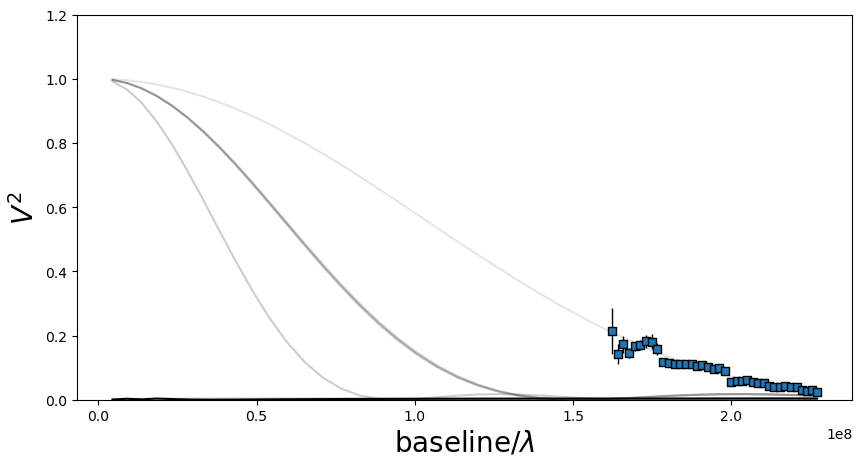

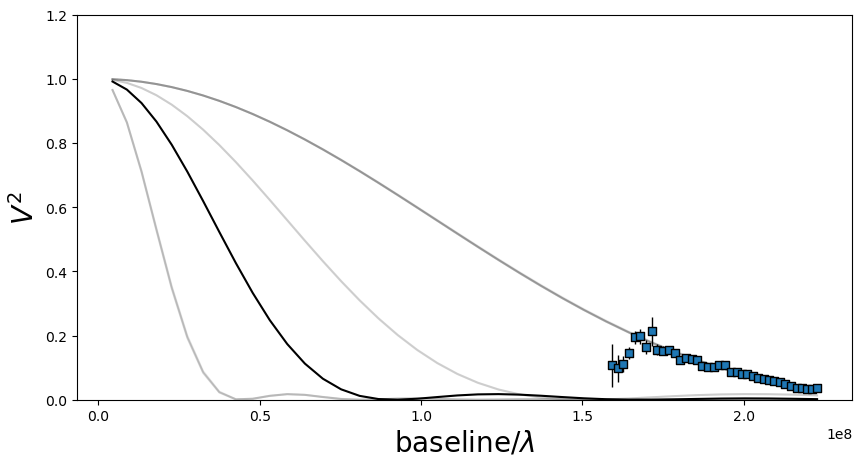

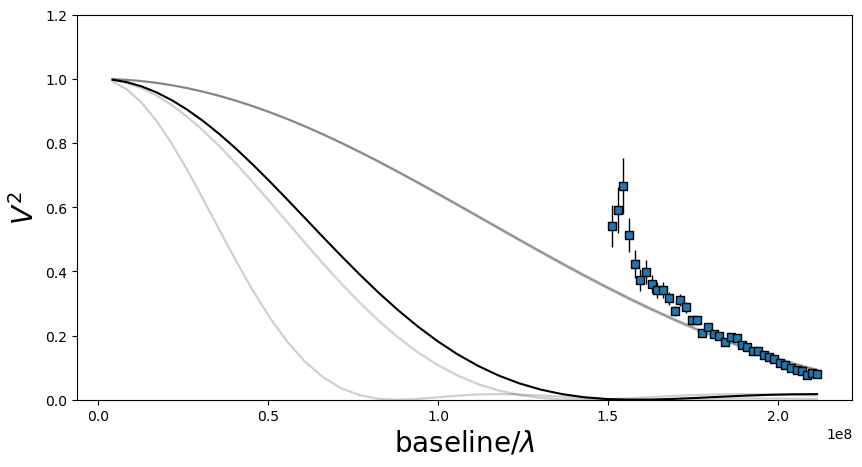

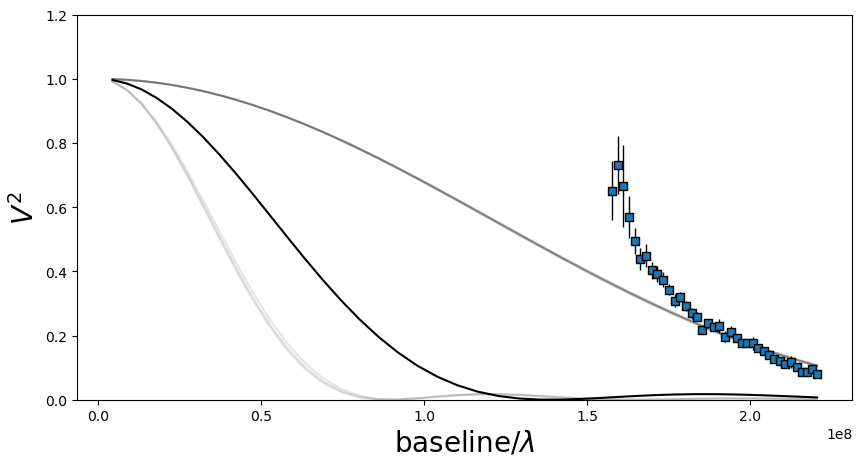

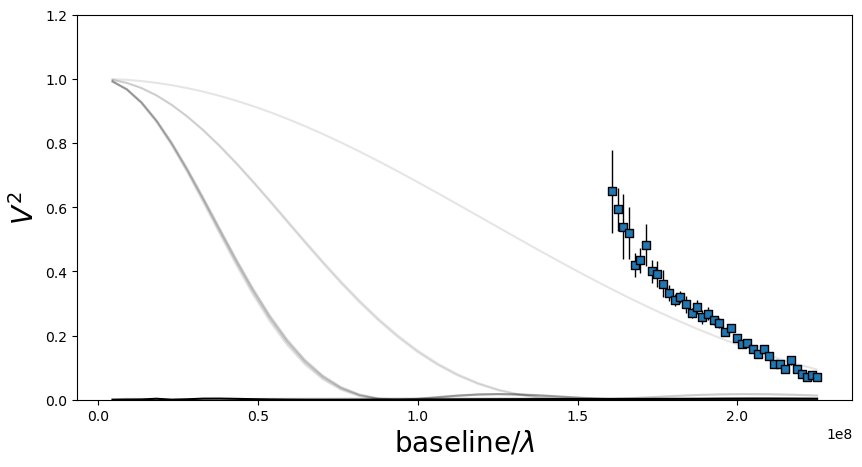

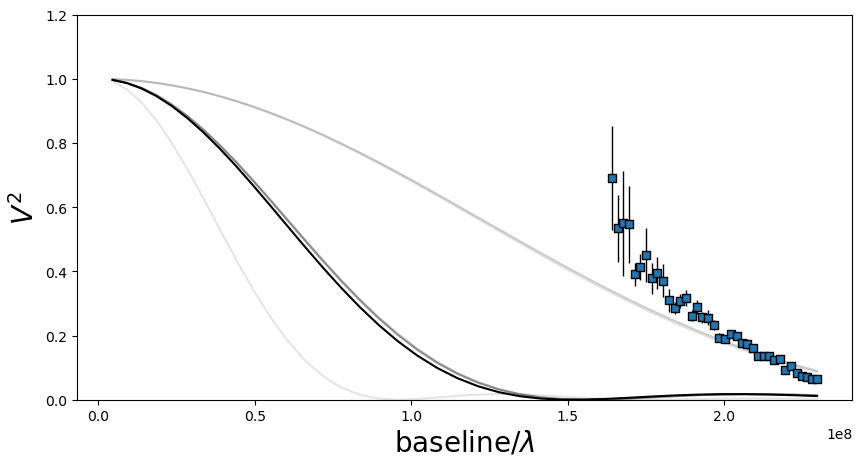

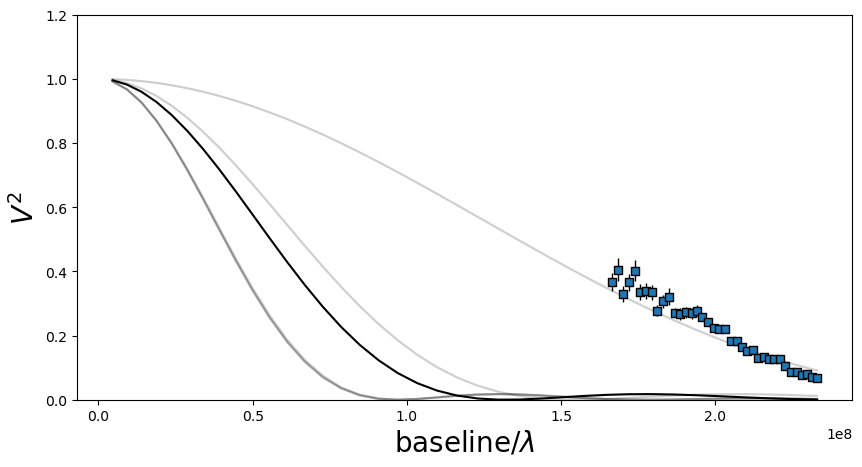

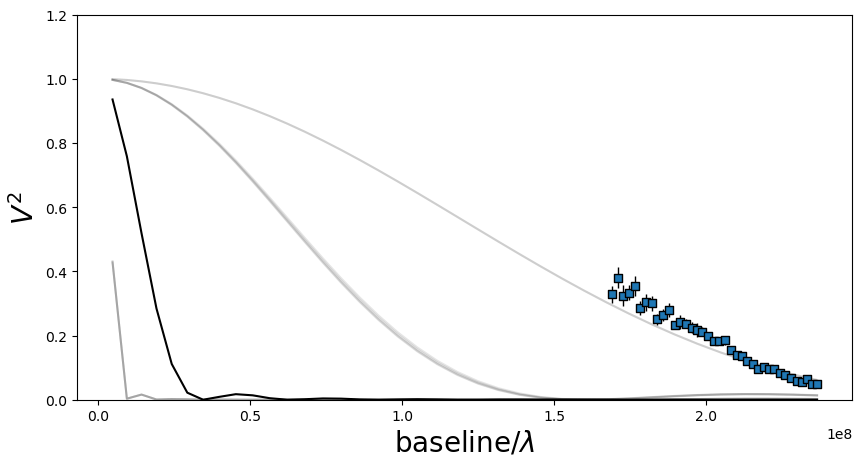

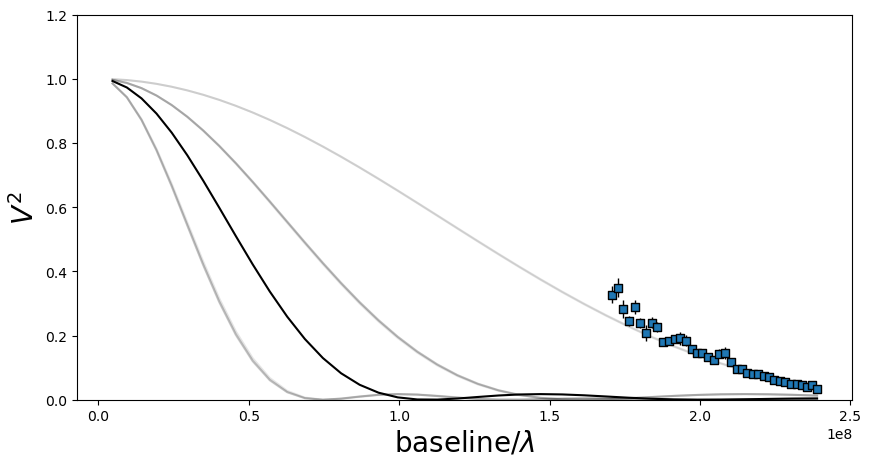

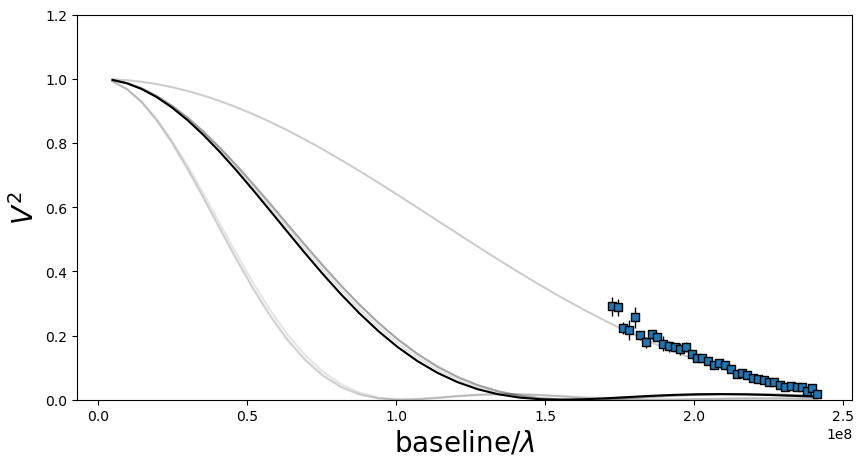

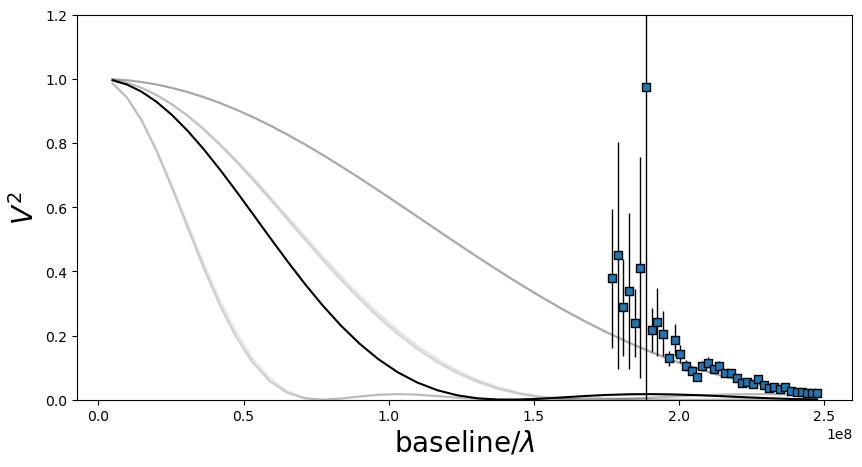

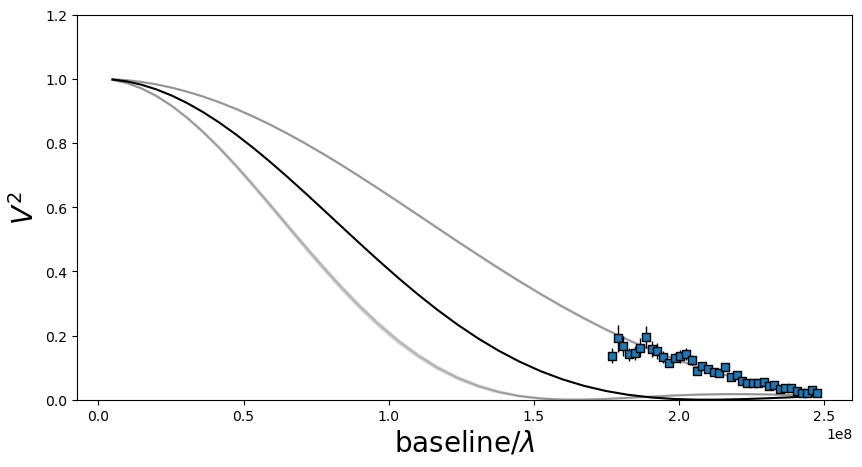

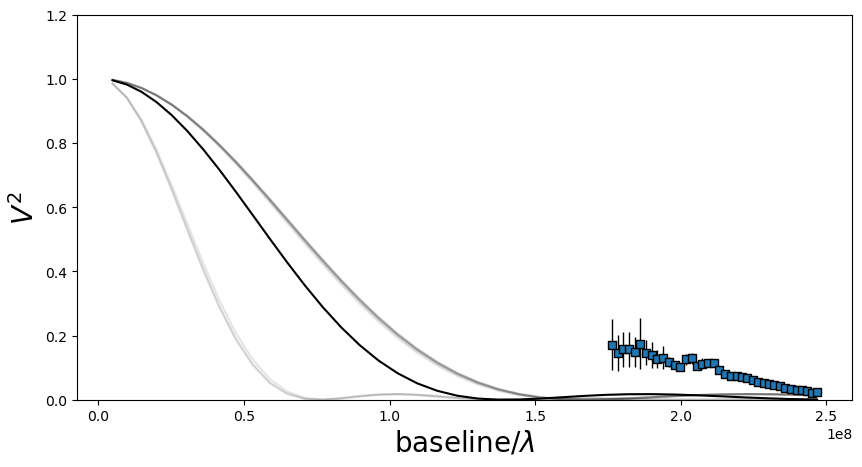

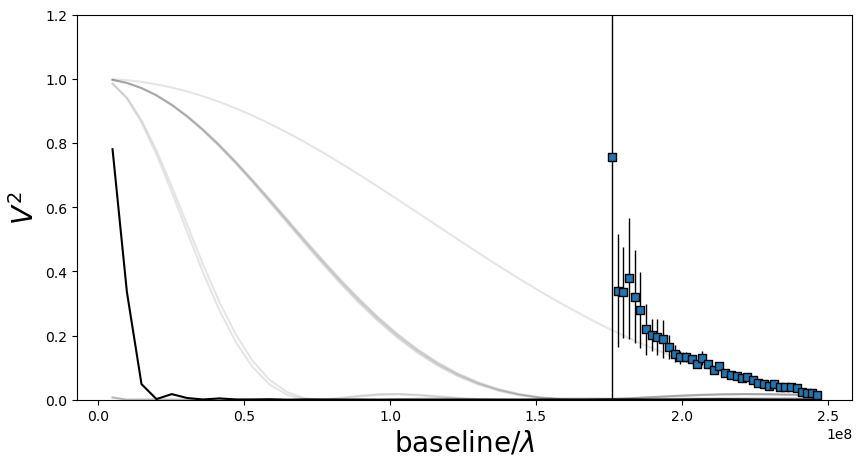

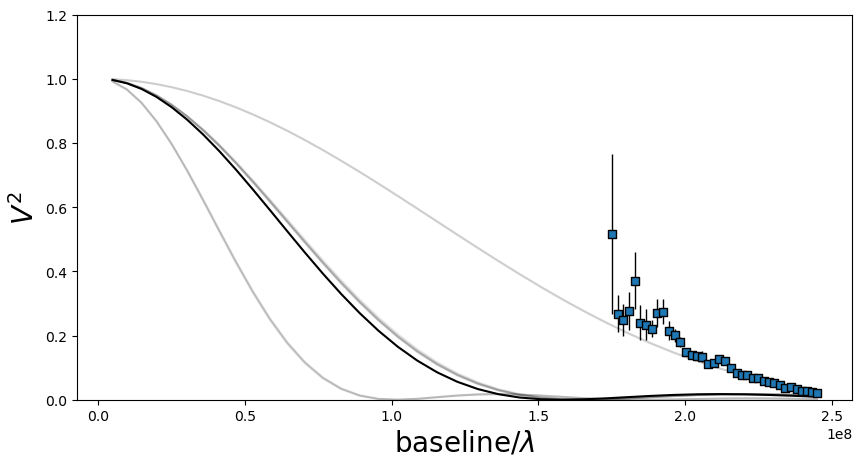

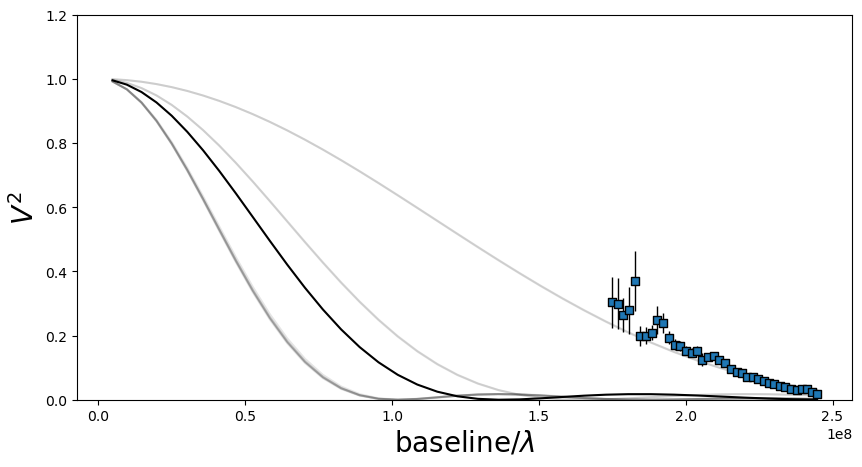

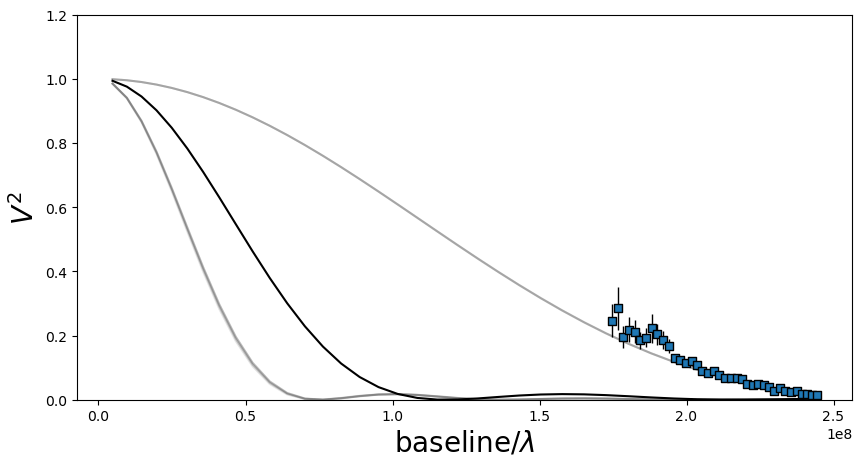

In [97]:
def plot_data(x,y, x0, y0, yerr, y0s,wavels=wav, alpha=1):
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    ax.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    
    ax.scatter(x, y, marker="s", s=30, edgecolor="k", zorder=1000)
    ax.plot(x0, y0, color="k", lw=1.5, alpha=alpha)
    for i in y0s:
        ax.plot(x0, i, color="k", lw=1.5, alpha=0.1)
    ax.set_xlabel("baseline/$\lambda$", fontsize=20)
    ax.set_ylabel("$V^2$", fontsize=20)
    ax.set_ylim(0, 1.2)

for i, th in enumerate(np.unique(theta)):
    df2 = df[np.array(theta==th) * np.array(df['STAR']=='HD_84999')]

    u = jnp.array(df2['UCOORDS'].values)
    v = jnp.array(df2['VCCORDS'].values)
    wav = jnp.array(df2['LAMBDA'].values)
    v2 = jnp.array(df2['V2CAL'].values)
    v2_err = jnp.array(df2['V2CALERR'].values)

    x = jnp.hypot(u/(wav*1e-6),v/(wav*1e-6))
    y = v2
    yerr = v2_err
    u0 = jnp.linspace(0,u.max(),len(wav))/(wav*1e-6)
    v0 = jnp.linspace(0,v.max(),len(wav))/(wav*1e-6)
    x0 = jnp.hypot(u0,v0)
    
    inf_data = az.from_numpyro(samplers[i])    
    diam = np.mean(inf_data.posterior.diam.values)

    y0 = vis_ud(diam,u0,v0)**2
    y0s = []
    for diam in np.random.choice(np.concatenate(inf_data.posterior.diam.values), 10):
        y0s.append(vis_ud(diam,u0,v0)**2)
    plot_data(x,y, x0, y0, yerr, y0s,wavels=wav, alpha=1)

In [ ]:
len(np.unique(wav))

In [ ]:
df

In [ ]:
np.unique(df.STAR)

In [ ]:
np.sum(df.V2CALERR<=0.0)

In [ ]:
np.sum((df.V2CAL <= 0.0))

In [ ]:
np.sum(df.V2CAL>=1.0)

In [ ]:
np.sum(df.LAMBDA==0)

In [ ]:
np.sum(df.STAR != 'HD_84999')